In [78]:
import pandas as pd
import numpy as np
import re
import string

In [79]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Conv1D,MaxPool1D,BatchNormalization, GRU, SimpleRNN, Dropout,Flatten, concatenate,Bidirectional, GlobalMaxPool1D
from tensorflow.keras import utils 
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
import matplotlib.pyplot as plt 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import random
import time
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import brown
from textblob import TextBlob
from tensorflow.keras import regularizers
from keras.initializers import Constant


In [80]:


import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)



In [81]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [82]:
tweets_train.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [83]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [84]:
tweets_train['cleaned_text'] = tweets_train['text'].apply(lambda x: clean_text(x))

In [85]:
tweets_test['cleaned_text'] = tweets_test['text'].apply(lambda x: clean_text(x))

In [86]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: remove_emoji(x))
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].apply(lambda x: remove_emoji(x))

In [87]:
tweets_train.cleaned_text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                                 s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: cleaned_text, Length: 7613, dtype: object

In [88]:
stop_words = stopwords.words('english') 
stops = r'\b({})\b'.format('|'.join(stop))

tweets_train['cleaned_text'] = tweets_train['cleaned_text'].str.replace(stops, '').str.replace('\s+', ' ')
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].str.replace(stops, '').str.replace('\s+', ' ')

tweets_train.cleaned_text

0           deeds reason earthquake may allah forgive us 
1                   forest fire near la ronge sask canada
2        residents asked shelter place notified office...
3        people receive wildfires evacuation orders ca...
4        got sent photo ruby alaska smoke wildfires po...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                      volcano hawaii 
7611    police investigating ebike collided car little...
7612     latest homes razed northern california wildfi...
Name: cleaned_text, Length: 7613, dtype: object

In [89]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [90]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [91]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [92]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [93]:
padded_sentences

array([[4156,  723,  142, ...,    0,    0,    0],
       [  94,    4,  124, ...,    0,    0,    0],
       [1514, 1392, 1880, ...,    0,    0,    0],
       ...,
       [ 459, 1381,    0, ...,    0,    0,    0],
       [  17,  953, 2889, ...,    0,    0,    0],
       [ 111,  106,  410, ...,    0,    0,    0]], dtype=int32)

In [94]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('Dataset/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [95]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [96]:
embedding_matrix.shape

(16644, 100)

In [97]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
y = np.asarray(train_target_emb)

In [103]:
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [104]:
xVal.shape

(1904, 23)

In [105]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
178/179 [============================>.] - ETA: 0s - loss: 0.7727 - accuracy: 0.5906
Epoch 00001: val_loss improved from inf to 0.63011, saving model to model.h5
179/179 [==============================] - 8s 47ms/step - loss: 0.7722 - accuracy: 0.5908 - val_loss: 0.6301 - val_accuracy: 0.7747
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.6085 - accuracy: 0.6829
Epoch 00002: val_loss improved from 0.63011 to 0.52180, saving model to model.h5
179/179 [==============================] - 7s 42ms/step - loss: 0.6082 - accuracy: 0.6830 - val_loss: 0.5218 - val_accuracy: 0.8136
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.7486
Epoch 00003: val_loss improved from 0.52180 to 0.45198, saving model to model.h5
179/179 [==============================] - 6s 35ms/step - loss: 0.5447 - accuracy: 0.7486 - val_loss: 0.4520 - val_accuracy: 0.8120
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.4951 

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 50)            841700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 62)            20336     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 62)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62)                248       
_________________________________________________________________
dropout_3 (Dropout)          (None, 62)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                1953      
_________________________________________________________________
dropout_4 (Dropout)          (None, 31)               

In [49]:
import matplotlib.pyplot as plt
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)


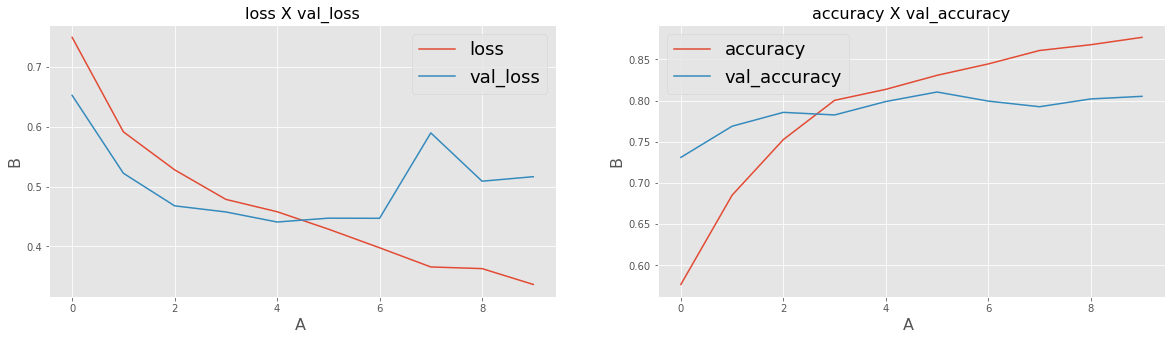

In [50]:


plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])



In [51]:
loss, accuracy = model.evaluate(xVal, yVal)
print('Loss:', loss)
print('Accuracy:', accuracy)

60/60 [==============================] - 0s 6ms/step - loss: 0.5167 - accuracy: 0.8051
Loss: 0.5167154669761658
Accuracy: 0.8051470518112183


In [52]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))


In [53]:
preds = model.predict_classes(xVal)
metrics(preds, yVal)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
F1-score:  0.7573577501635057
Precision:  0.6942446043165468
Recall:  0.8330935251798561
Acuracy:  0.8051470588235294
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1209
           1       0.69      0.83      0.76       695

    accuracy                           0.81      1904
   macro avg       0.79      0.81      0.80      1904
weighted avg       0.82      0.81      0.81      1904



In [54]:
model.load_weights('model.h5')
preds = model.predict_classes(xVal)
metrics(preds, yVal)

F1-score:  0.7441549766199065
Precision:  0.6678657074340527
Recall:  0.8401206636500754
Acuracy:  0.7988445378151261
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1241
           1       0.67      0.84      0.74       663

    accuracy                           0.80      1904
   macro avg       0.78      0.81      0.79      1904
weighted avg       0.82      0.80      0.80      1904



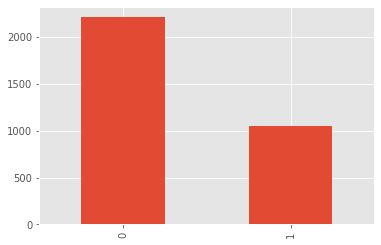

In [56]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)
tweets_submission.target.value_counts().plot.bar();